In [1]:
# Import necessary libraries
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [5]:
# Load the enhanced dataset
training_data = pd.read_csv("large_enhanced_training_data.csv")
validation_data = pd.read_csv("large_enhanced_validation_data.csv")

# Separate features and labels
X_train = training_data.drop(columns=['PFS_Label'])
y_train = training_data['PFS_Label']

X_valid = validation_data.drop(columns=['PFS_Label'])
y_valid = validation_data['PFS_Label']
training_data.head(20)

,Age,Sex,Histology,Prior_Trastuzumab_Use,Duration_First_Line_Chemo,Age_x_Histology,Gene_1,Gene_2,Gene_3,Gene_4,...,Gene_79,Gene_80,Gene_81,Gene_82,Gene_83,Gene_84,Gene_85,Gene_86,Gene_87,PFS_Label
0,44,Male,Intestinal,0,<3 months,44,0.009184,0.265696,0.302401,0.172796,...,0.000000,1.000000,0.966154,0.349488,0.970359,0.408652,1.000000,0.189614,1.000000,Paclitaxel-Resistant
1,33,Female,Intestinal,1,>6 months,33,1.000000,1.000000,0.622755,0.000000,...,0.000000,0.687264,0.000000,0.084929,0.000000,0.088953,1.000000,0.000000,0.681902,Paclitaxel-Sensitive
2,35,Male,Diffuse,0,<3 months,0,0.723441,1.000000,0.361809,1.000000,...,0.000000,0.912371,0.000000,1.000000,1.000000,1.000000,0.075871,1.000000,0.949115,Paclitaxel-Resistant
3,60,Female,Diffuse,1,>6 months,0,0.062955,1.000000,0.083766,1.000000,...,0.305877,0.971099,0.007860,1.000000,0.877840,1.000000,1.000000,1.000000,0.881415,Paclitaxel-Resistant
4,83,Male,Intestinal,0,3-6 months,83,0.287755,0.142280,0.000000,0.898620,...,0.159163,0.018119,0.948077,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,Paclitaxel-Sensitive
5,33,Male,Intestinal,0,>6 months,33,0.000000,1.000000,0.130019,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.059642,0.000000,0.868536,0.000000,0.000000,Paclitaxel-Sensitive
6,34,Female,Intestinal,0,>6 months,34,1.000000,0.009612,0.867630,1.000000,...,1.000000,0.772435,0.000000,0.000000,1.000000,1.000000,1.000000,0.250159,0.036022,Paclitaxel-Sensitive
7,82,Male,Intestinal,0,3-6 months,82,1.000000,0.894438,0.863839,0.920410,...,0.000000,0.831724,1.000000,1.000000,0.000000,1.000000,0.696762,0.285724,0.104953,Paclitaxel-Resistant
8,80,Female,Intestinal,0,3-6 months,80,0.417775,0.000000,0.000000,1.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,0.686047,0.883388,0.000000,1.000000,Paclitaxel-Sensitive
9,55,Female,Intestinal,0,<3 months,55,0.339372,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.068009,0.000000,0.959449,1.000000,1.000000,Paclitaxel-Resistant


In [7]:
# Encode categorical columns
categorical_columns = ['Sex', 'Histology', 'Duration_First_Line_Chemo']
for col in categorical_columns:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_valid[col] = le.transform(X_valid[col])

# Encode labels
le_label = LabelEncoder()
y_train_encoded = le_label.fit_transform(y_train)
y_valid_encoded = le_label.transform(y_valid)

In [4]:
# Model Configurations
models = {}

# Random Forest
models["Random Forest"] = RandomForestClassifier(
    n_estimators=30,
    max_depth=3,  
    min_samples_split=20,  # Prevent small splits
    class_weight='balanced',
    random_state=42
)

In [5]:
# Logistic Regression
models["Logistic Regression"] = LogisticRegression(
    penalty='l2',
    C=0.0001,  # Stronger regularization
    class_weight='balanced',
    max_iter=2000
)

In [6]:
# ANN
models["ANN"] = MLPClassifier(
    hidden_layer_sizes=(20, 10),  # Two hidden layers
    activation='relu',
    solver='adam',
    alpha=0.5,  # L2 regularization
    max_iter=3000,
    random_state=42
)

In [7]:
# ANN with Genetic Embedding
class ANNWithEmbedding(nn.Module):
    def __init__(self, clinical_input_size, genomic_input_size, embedding_dim):
        super(ANNWithEmbedding, self).__init__()
        self.embedding = nn.Linear(genomic_input_size, embedding_dim)
        self.fc1 = nn.Linear(clinical_input_size + embedding_dim, 20)
        self.fc2 = nn.Linear(20, 10)
        self.output = nn.Linear(10, 2)
        self.dropout = nn.Dropout(0.5)

    def forward(self, clinical_data, genomic_data):
        genomic_embedding = torch.relu(self.embedding(genomic_data))
        combined_data = torch.cat((clinical_data, genomic_embedding), dim=1)
        x = torch.relu(self.fc1(combined_data))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        return self.output(x)

In [8]:
# Prepare data for PyTorch ANN with Genetic Embedding
clinical_columns = ['Age', 'Sex', 'Histology', 'Prior_Trastuzumab_Use', 'Duration_First_Line_Chemo', 'Age_x_Histology']
genomic_columns = [col for col in X_train.columns if col.startswith('Gene_')]

X_train_clinical = torch.tensor(X_train[clinical_columns].values, dtype=torch.float32)
X_train_genomic = torch.tensor(X_train[genomic_columns].values, dtype=torch.float32)
y_train_torch = torch.tensor(y_train_encoded, dtype=torch.long)

X_valid_clinical = torch.tensor(X_valid[clinical_columns].values, dtype=torch.float32)
X_valid_genomic = torch.tensor(X_valid[genomic_columns].values, dtype=torch.float32)
y_valid_torch = torch.tensor(y_valid_encoded, dtype=torch.long)

train_dataset = TensorDataset(X_train_clinical, X_train_genomic, y_train_torch)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Initialize ANN with Embedding
embedding_dim = 10
ann_embedding_model = ANNWithEmbedding(len(clinical_columns), len(genomic_columns), embedding_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ann_embedding_model.parameters(), lr=0.001)

# Train ANN with Genetic Embedding
for epoch in range(30):  # Train for 30 epochs
    ann_embedding_model.train()
    for clinical_data, genomic_data, labels in train_loader:
        optimizer.zero_grad()
        outputs = ann_embedding_model(clinical_data, genomic_data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

In [9]:
# Evaluate Models
results = {}

for name, model in models.items():
    # Train and evaluate scikit-learn models
    model.fit(X_train, y_train_encoded)
    train_preds = model.predict(X_train)
    train_probs = model.predict_proba(X_train)[:, 1]
    valid_preds = model.predict(X_valid)
    valid_probs = model.predict_proba(X_valid)[:, 1]

    results[name] = {
        "Training Metrics": {
            "AUROC": roc_auc_score(y_train_encoded, train_probs),
            "Accuracy": accuracy_score(y_train_encoded, train_preds),
            "F1-Score": f1_score(y_train_encoded, train_preds)
        },
        "Validation Metrics": {
            "AUROC": roc_auc_score(y_valid_encoded, valid_probs),
            "Accuracy": accuracy_score(y_valid_encoded, valid_preds),
            "F1-Score": f1_score(y_valid_encoded, valid_preds)
        }
    }

In [10]:
# Evaluate ANN with Genetic Embedding
ann_embedding_model.eval()
with torch.no_grad():
    outputs_train = ann_embedding_model(X_train_clinical, X_train_genomic)
    train_preds = torch.argmax(outputs_train, dim=1).numpy()
    train_probs = torch.softmax(outputs_train, dim=1)[:, 1].numpy()
    outputs_valid = ann_embedding_model(X_valid_clinical, X_valid_genomic)
    valid_preds = torch.argmax(outputs_valid, dim=1).numpy()
    valid_probs = torch.softmax(outputs_valid, dim=1)[:, 1].numpy()

results["ANN with Genetic Embedding"] = {
    "Training Metrics": {
        "AUROC": roc_auc_score(y_train_encoded, train_probs),
        "Accuracy": accuracy_score(y_train_encoded, train_preds),
        "F1-Score": f1_score(y_train_encoded, train_preds)
    },
    "Validation Metrics": {
        "AUROC": roc_auc_score(y_valid_encoded, valid_probs),
        "Accuracy": accuracy_score(y_valid_encoded, valid_preds),
        "F1-Score": f1_score(y_valid_encoded, valid_preds)
    }
}

In [11]:
# Print results
for model_name, metrics in results.items():
    print(f"\nModel: {model_name}")
    print(f"  Training Metrics: {metrics['Training Metrics']}")
    print(f"  Validation Metrics: {metrics['Validation Metrics']}")


Model: Random Forest
  Training Metrics: {'AUROC': 0.6918871392568169, 'Accuracy': 0.62125, 'F1-Score': 0.6188679245283019}
  Validation Metrics: {'AUROC': 0.6399594155844156, 'Accuracy': 0.59, 'F1-Score': 0.5816326530612245}

Model: Logistic Regression
  Training Metrics: {'AUROC': 0.6083224376101415, 'Accuracy': 0.588, 'F1-Score': 0.6144127281235376}
  Validation Metrics: {'AUROC': 0.5781006493506493, 'Accuracy': 0.573, 'F1-Score': 0.5913875598086125}

Model: ANN
  Training Metrics: {'AUROC': 0.6959864577214359, 'Accuracy': 0.6315, 'F1-Score': 0.6041890440386681}
  Validation Metrics: {'AUROC': 0.5926623376623377, 'Accuracy': 0.553, 'F1-Score': 0.5239616613418531}

Model: ANN with Genetic Embedding
  Training Metrics: {'AUROC': 0.619518314289504, 'Accuracy': 0.59125, 'F1-Score': 0.5603656897015327}
  Validation Metrics: {'AUROC': 0.5759862012987013, 'Accuracy': 0.572, 'F1-Score': 0.5307017543859649}


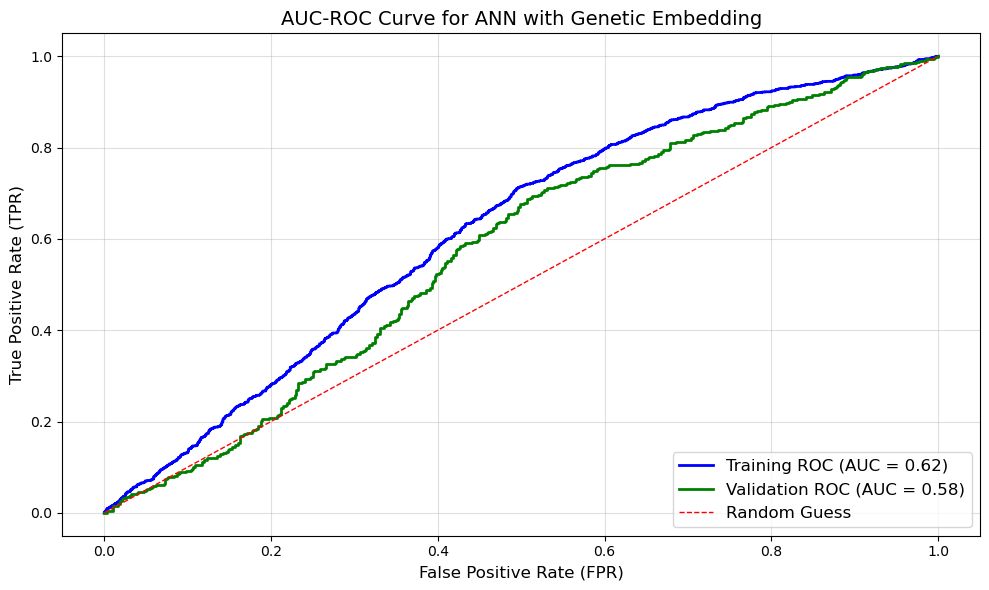

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot AUC-ROC curves for the ANN with Genetic Embedding model
plt.figure(figsize=(10, 6))

# Calculate ROC for the training set
fpr_train, tpr_train, _ = roc_curve(y_train_encoded, train_probs)
roc_auc_train = auc(fpr_train, tpr_train)

# Calculate ROC for the validation set
fpr_valid, tpr_valid, _ = roc_curve(y_valid_encoded, valid_probs)
roc_auc_valid = auc(fpr_valid, tpr_valid)

# Plot ROC curve for the training set
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Training ROC (AUC = {roc_auc_train:.2f})')

# Plot ROC curve for the validation set
plt.plot(fpr_valid, tpr_valid, color='green', lw=2, label=f'Validation ROC (AUC = {roc_auc_valid:.2f})')

# Add diagonal line for random guessing
plt.plot([0, 1], [0, 1], color='red', lw=1, linestyle='--', label='Random Guess')

# Customize the plot
plt.title('AUC-ROC Curve for ANN with Genetic Embedding', fontsize=14)
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.4)
plt.tight_layout()

# Show the plot
plt.show()


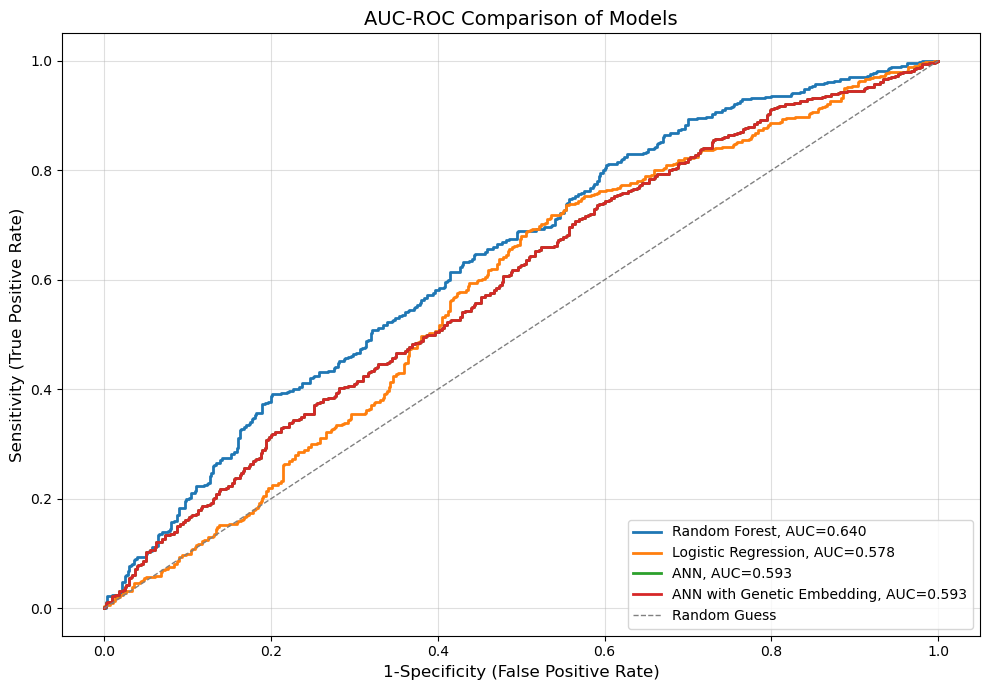

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Collect predicted probabilities for validation set from all models
models_probs = {}

# Scikit-learn models
for name, model in models.items():
    valid_probs = model.predict_proba(X_valid)[:, 1]  # Get probabilities for the positive class
    models_probs[name] = valid_probs

# ANN with Genetic Embedding
models_probs["ANN with Genetic Embedding"] = valid_probs  # ANN validation probabilities

# Plot ROC curves
plt.figure(figsize=(10, 7))

# Actual labels for validation set
y_valid_actual = y_valid_encoded

# Plot each model's ROC curve
for model_name, model_probs in models_probs.items():
    fpr, tpr, _ = roc_curve(y_valid_actual, model_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{model_name}, AUC={roc_auc:.3f}')

# Add diagonal line for random guessing
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--', label='Random Guess')

# Customize plot
plt.title('AUC-ROC Comparison of Models', fontsize=14)
plt.xlabel('1-Specificity (False Positive Rate)', fontsize=12)
plt.ylabel('Sensitivity (True Positive Rate)', fontsize=12)
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.4)
plt.tight_layout()

# Show plot
plt.show()
